## HT5 - Proyecto 2 Entrega 3 – Naive Bayes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regresion
from sklearn.model_selection import train_test_split
#Importar Datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
house_prices=pd.read_csv("train.csv")

### Modelo de Regresion (Naive Bayes)

In [2]:
X = regresion.drop_many_nulls(house_prices).dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1100 non-null   int64  
 1   MSZoning       1100 non-null   object 
 2   LotFrontage    1100 non-null   float64
 3   LotArea        1100 non-null   int64  
 4   Street         1100 non-null   object 
 5   LotShape       1100 non-null   object 
 6   LandContour    1100 non-null   object 
 7   Utilities      1100 non-null   object 
 8   LotConfig      1100 non-null   object 
 9   LandSlope      1100 non-null   object 
 10  Neighborhood   1100 non-null   object 
 11  Condition1     1100 non-null   object 
 12  Condition2     1100 non-null   object 
 13  BldgType       1100 non-null   object 
 14  HouseStyle     1100 non-null   object 
 15  OverallQual    1100 non-null   int64  
 16  OverallCond    1100 non-null   int64  
 17  YearBuilt      1100 non-null   int64  
 18  YearRemodAdd 

### Test/Train

(array([ 12.,  75., 298., 250., 178., 101.,  70.,  39.,  28.,  22.,  10.,
          6.,   3.,   1.,   2.,   1.,   2.,   0.,   0.,   2.]),
 array([ 35311.  ,  71295.45, 107279.9 , 143264.35, 179248.8 , 215233.25,
        251217.7 , 287202.15, 323186.6 , 359171.05, 395155.5 , 431139.95,
        467124.4 , 503108.85, 539093.3 , 575077.75, 611062.2 , 647046.65,
        683031.1 , 719015.55, 755000.  ]),
 <BarContainer object of 20 artists>)

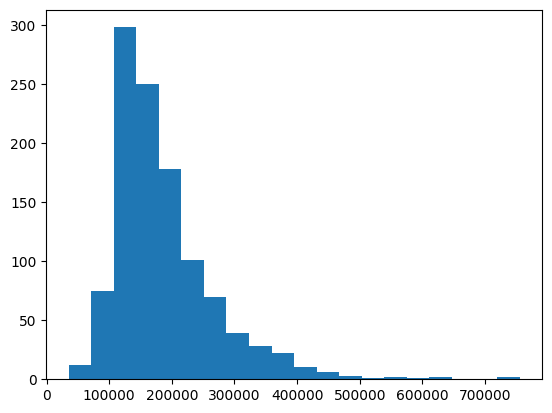

In [3]:
plt.hist(X['SalePrice'], bins=20)

In [4]:
y = X.pop("SalePrice")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(770, 57)
(330, 57)
(770,)
(330,)


### Cat y Num processing

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

cat_pp = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
num_pp = StandardScaler()
pp = ColumnTransformer([
    ('one-hot-encoder', cat_pp,categorical_columns),
    ('standard-scaler', num_pp,numerical_columns)
    ])

### Preprocessing

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
pipeline = Pipeline(
    [('preprocessor',pp),
     ('regressor',GaussianNB())])

In [8]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

gnb = pipeline.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
rmse = root_mean_squared_error(y_test,y_pred)
print("RMSE: ",rmse)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")
# model = GaussianNB.predict(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# rmse = root_mean_squared_error(y_test,y_pred)
# rmse

RMSE:  77211.88494500445
MAE: 41902.3727
MSE: 5961675176.7606


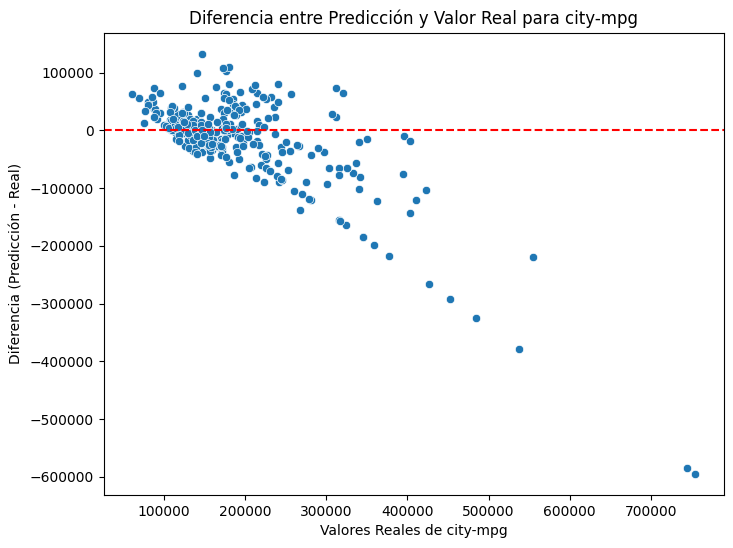

In [9]:
import seaborn as sns
differences = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=differences)
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para ver las diferencias
plt.xlabel('Valores Reales de city-mpg')
plt.ylabel('Diferencia (Predicción - Real)')
plt.title('Diferencia entre Predicción y Valor Real para city-mpg')
plt.show()

## Clasificacion

In [39]:
import classification
X = regresion.drop_many_nulls(house_prices)
data_nbc = classification.sale_price_replace(X)
data_nbc = data_nbc.select_dtypes([float,int])
print(data_nbc.isna().sum()) 
y_nbc = data_nbc.pop('SpThird') # Nueva variable de salida
X_nbc = data_nbc
X_train, X_test,y_train, y_test = train_test_split(X_nbc, y_nbc,test_size=0.3,train_size=0.7,  random_state=42)


MSSubClass        0
LotFrontage     259
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
TotalBsmtSF       0
1stFlrSF          0
GrLivArea         0
BsmtFullBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt      81
GarageCars        0
GarageArea        0
MoSold            0
YrSold            0
SpThird           0
dtype: int64


c:\Users\JM\Documents\Data Mining\Naive_Bayes\classification.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = km.fit_predict(X_pca)


In [38]:
from sklearn.metrics import confusion_matrix
gaussian = GaussianNB() # distribución gaussiana. ¿qué significa y qué implica? 

# train
gaussian.fit(X_train,y_train)

# prediction
y_pred = gaussian.predict(X_test)

# eval_model
cm = confusion_matrix(y_test,y_pred)

ValueError: Input X contains NaN.
GaussianNB does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values